# Introduction

This tutorial demonstrates how to achieve phase and orientation mapping via scanning electron diffraction using both pattern and vector matching.

The data was acquired from a GaAs nanowire displaying polymorphism between zinc blende and wurtzite structures.

This functionaility has been checked to run in pyxem-0.11.0 (May 2020). Bugs are always possible, do not trust the code blindly, and if you experience any issues please report them here: https://github.com/pyxem/pyxem-demos/issues

1. <a href='#loa'> Load & Inspect Data</a>
2. <a href='#pre'> Pre-processing</a>
3. <a href='#tem'> Template matching</a>
    1. <a href='#tema'> [Build Template Library]</a>
    2. <a href='#temb'>[Indexing]</a>
4. <a href='#vec'> Vector Matching</a>
    1. <a href='#veca'> [Build Vector Library]</a>
    2. <a href='#vecb'>[Indexing Vectors]</a>

# <a id='tem'></a> 3. Pattern Matching

Pattern matching generates a database of simulated diffraction patterns and then compares all simulated patterns against each experimental pattern to find the best match

Import generators required for simulation and indexation

In [3]:
%matplotlib notebook
#chanegd from %matplotlib qt to notebook so 
import diffpy.structure 
from diffsims.libraries.structure_library import StructureLibrary
from diffsims.generators.diffraction_generator import DiffractionGenerator
from diffsims.generators.library_generator import DiffractionLibraryGenerator
from diffsims.generators.zap_map_generator import get_rotation_from_z_to_direction
from diffsims.generators.rotation_list_generators import get_grid_around_beam_direction
# added next line
import numpy as np

## 3.1. Define Library of Structures & Orientations

Define the crystal phases to be included in the simulated library

In [4]:
#changed the pointer location here
structure_zb = diffpy.structure.loadStructure('./GaAs_cif/GaAs_mp-2534_conventional_standard.cif')
structure_wz = diffpy.structure.loadStructure('./GaAs_cif/GaAs_mp-8883_conventional_standard.cif')

Create a basic rotations list.    

In [5]:
za110c = get_rotation_from_z_to_direction(structure_zb, [1,1,0])
rot_list_cubic = get_grid_around_beam_direction(beam_rotation=za110c, resolution=1, angular_range=(0,180))

In [6]:
za110h = get_rotation_from_z_to_direction(structure_wz, [1,1,0])
rot_list_hex = get_grid_around_beam_direction(beam_rotation=za110h, resolution=1, angular_range=(0,180))

Construct a StructureLibrary defining crystal structures and orientations for which diffraction will be simulated 

In [7]:
struc_lib = StructureLibrary(['ZB','WZ'],
                             [structure_zb,structure_wz],
                             [rot_list_cubic,rot_list_hex])

## <a id='temb'></a> 3.2. Simulate Diffraction for all Structures & Orientations

Define a diffsims DiffractionGenerator with diffraction simulation parameters

In [8]:
diff_gen = DiffractionGenerator(accelerating_voltage=300,
                                max_excitation_error=1/10)

Initialize a diffsims DiffractionLibraryGenerator

In [9]:
lib_gen = DiffractionLibraryGenerator(diff_gen)

Calulate library of diffraction patterns for all phases and unique orientations

In [10]:

half_size = 128
#set the diffraction_calibration here with value as in the external code
recip_d111 = np.sqrt((3/5.6535**2))
recip_cal = recip_d111 / 11.4

diffraction_calibration = recip_cal
reciprocal_radius = diffraction_calibration*(half_size - 1)

diff_lib = lib_gen.get_diffraction_library(struc_lib,
                                           calibration=diffraction_calibration,
                                           reciprocal_radius=reciprocal_radius,
                                           half_shape=(half_size, half_size),
                                           with_direct_beam=False)

Optionally, save the library for later use.

In [13]:
diff_lib.pickle_library('./GaAs_cubic_hex.pickle')

If saved, the library can be loaded as follows

In [14]:
from diffsims.libraries.diffraction_library import load_DiffractionLibrary

diff_lib = load_DiffractionLibrary('./GaAs_cubic_hex.pickle', safety=True)

# <a id='vec'></a> 4. Vector Matching

Vector matching generates a database of vector pairs (magnitues and inter-vector angles) and then compares all theoretical values against each measured diffraction vector pair to find the best match

Import generators required for simulation and indexation

In [15]:
from diffsims.generators.library_generator import VectorLibraryGenerator
from diffsims.libraries.structure_library import StructureLibrary
from diffsims.libraries.vector_library import load_VectorLibrary

from pyxem.generators.indexation_generator import VectorIndexationGenerator

from pyxem.generators.subpixelrefinement_generator import SubpixelrefinementGenerator
from pyxem.signals.diffraction_vectors import DiffractionVectors

## <a id='veca'></a> 4.1. Define Library of Structures

Define crystal structure for which to determine theoretical vector pairs

In [16]:
structure_zb = diffpy.structure.loadStructure('./GaAs_cif/GaAs_mp-2534_conventional_standard.cif')
structure_wz = diffpy.structure.loadStructure('./GaAs_cif/GaAs_mp-8883_conventional_standard.cif')

structure_library = StructureLibrary(['ZB', 'WZ'],
                                     [structure_zb, structure_wz],
                                     [[], []])

Initialize VectorLibraryGenerator with structures to be considered

In [17]:
vlib_gen = VectorLibraryGenerator(structure_library)

Determine VectorLibrary with all vectors within given reciprocal radius

In [20]:
#changed delete recipricol radius definition as defined in cell In[8]:
#this is the cell which is erroring
vec_lib = vlib_gen.get_vector_library(1)

100%|██████████| 2/2 [00:00<00:00,  3.02it/s]


Optionally, save the library for later use

In [21]:
vec_lib.pickle_library('./GaAs_cubic_hex_vectors.pickle')

In [22]:
vec_lib = load_VectorLibrary('./GaAs_cubic_hex_vectors.pickle',
                             safety=True)

## <a id='veca'></a> 5. Calculate profile data

Calling the calculate_profile_data method from the diffsims diffraction generator libary fror the zinc-blende structure

In [23]:
prof_sim_zb = diff_gen.calculate_profile_data(structure_zb, reciprocal_radius=reciprocal_radius)


Plot the simulation profile for the ZB structure

<IPython.core.display.Javascript object>


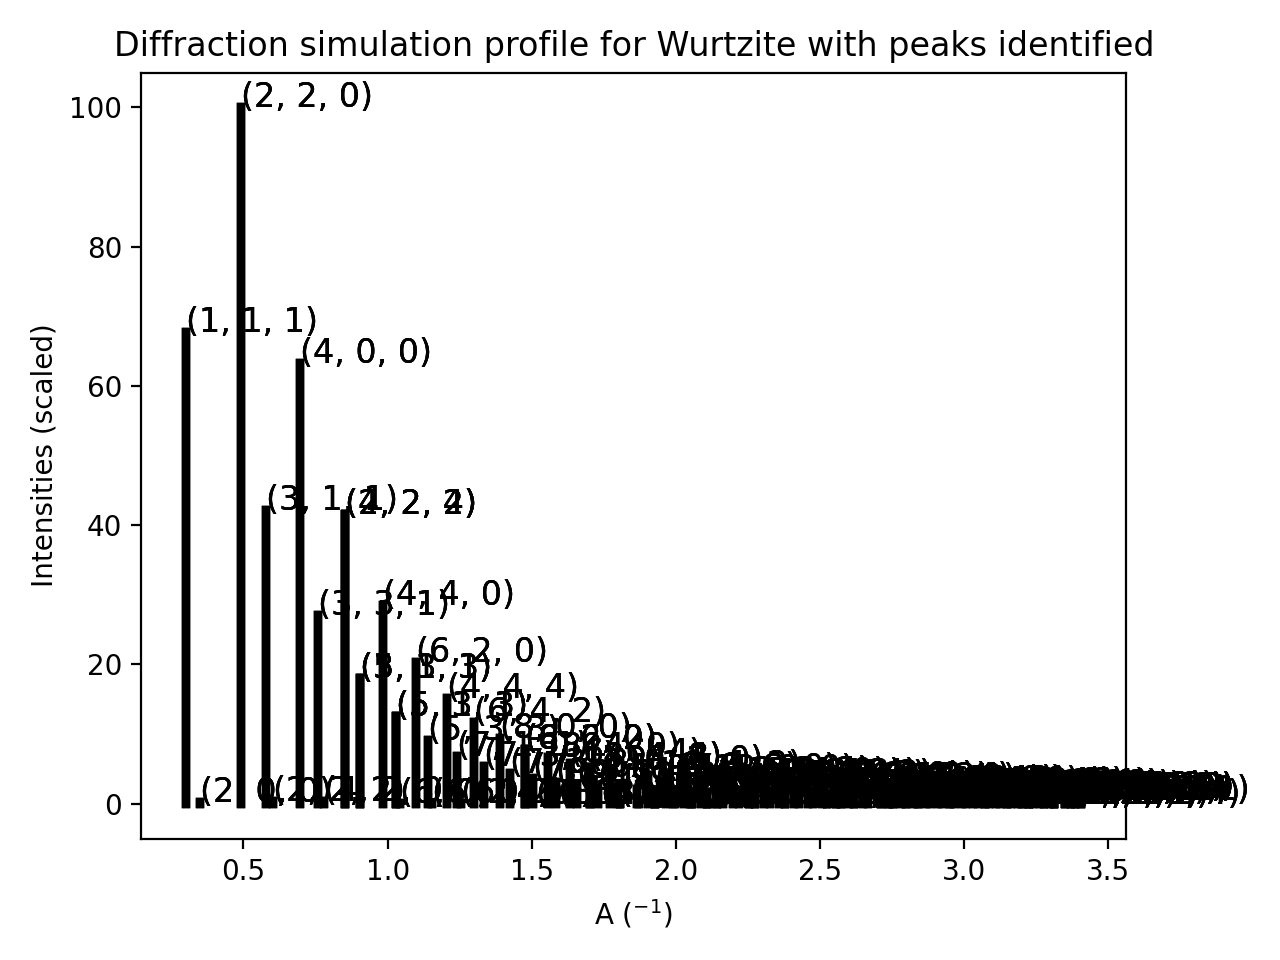

In [24]:

plt_zb = prof_sim_zb.get_plot(5)
plt_zb.title('Diffraction simulation profile for Zinc Blende with peaks identified')
plt_zb.tight_layout()
plt_zb.show()



Do the same for other structures (Wurtzite done here)

In [25]:
prof_sim_wz = diff_gen.calculate_profile_data(structure_wz, reciprocal_radius=reciprocal_radius)



<IPython.core.display.Javascript object>


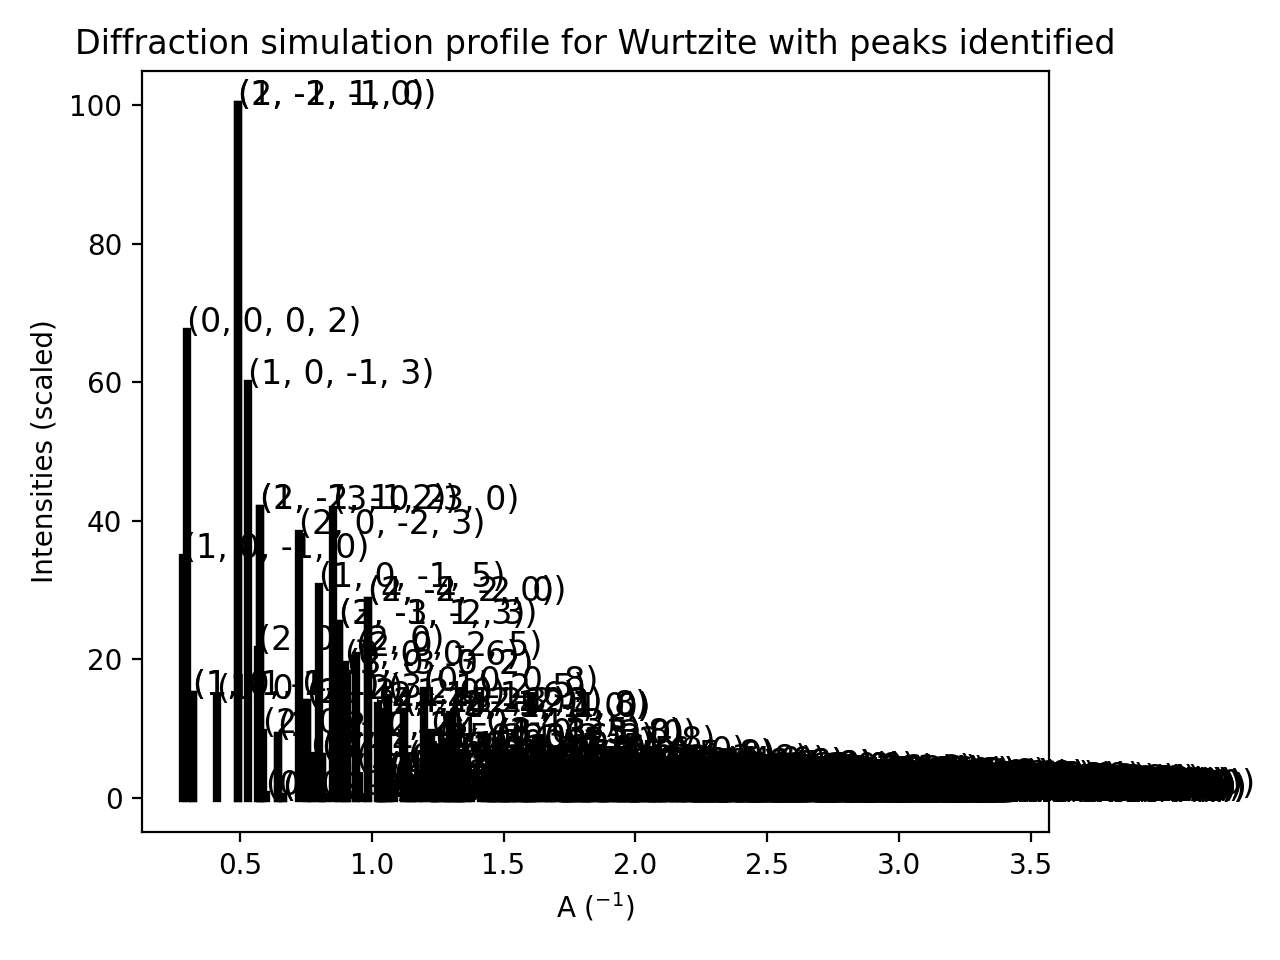

In [29]:
plt_wz = prof_sim_wz.get_plot(5)
plt_wz.title('Diffraction simulation profile for Wurtzite with peaks identified')
plt_wz.tight_layout()
plt_wz.show()

3.4130456767387907